In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)
GALARY = '/tigress/jiaxuanl/public_html/galary/'

### Try to plot the difference between UDG and UPG

In [45]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [46]:
name = 'upg'
thresh = 1.5
upg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
upg_cat = upg_cat[upg_cat['completeness'] > 0.1]
upg_cat.sort('g-i', reverse=True)

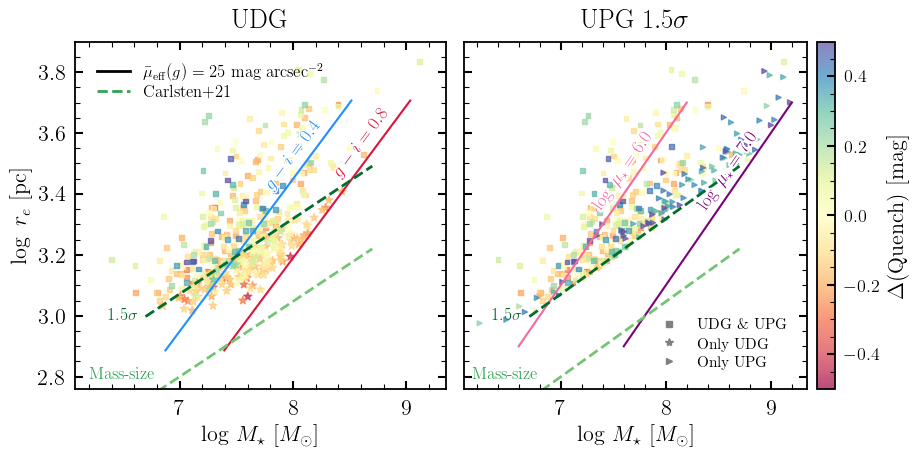

In [52]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9.8, 4.6), sharey=True, sharex=True)

plt.sca(ax1)

name = 'udg'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
udg_cat.sort('g-i', reverse=True)

quenched_intercept = -0.23
V = udg_cat['mag'][:, 0] - 0.5784 * \
    (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(udg_cat['host_ang_diam_dist'].data *
                              (1 + udg_cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. 
# The original intercept is -0.23. I think 0.28 works better for our sample.
delta_MS = -(udg_cat['g-i'] - (-0.067 * V_abs + quenched_intercept))
z = delta_MS

isupg = np.in1d(udg_cat['viz-id'], upg_cat['viz-id'])
sct = plt.scatter(
    udg_cat['log_m_star'][isupg], 
    np.log10(udg_cat['rhalf_phys'][isupg]) + 3, # in pc
    c=z[isupg], marker='s', s=12, vmin=-0.5, vmax=0.5, cmap='Spectral',
    alpha=0.7)
sct = plt.scatter(
    udg_cat['log_m_star'][~isupg], 
    np.log10(udg_cat['rhalf_phys'][~isupg]) + 3, # in pc
    c=z[~isupg], marker='*', vmin=-0.5, vmax=0.5, cmap='Spectral',
    alpha=0.7)

plt.xlabel(r'$\log\, M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_e$ [pc]')
plt.title(r'UDG')

dist = 100
g_mag = np.linspace(17.9, 22., 100)
g_abs = g_mag - 25 - 5 * np.log10(dist)
colors = ['dodgerblue', 'crimson']#['#f768a1','#c51b8a','#7a0177']
for i, gi in enumerate([0.4, 0.8]):
    log_ML_g = 1.297 * gi - 0.855
    log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
    SB = 25
    re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
    re_phys = (re_ang / 206265) * dist * 1000
    plt.plot(log_m_star, np.log10(re_phys) + 3, color=colors[i], 
             label=f'$g-i={gi}$')
from labellines import labelLines
labelLines(ax1.get_lines(), zorder=12, xvals=[8, 8.6], shrink_factor=0.2, fontsize=13, 
           outline_color='auto', outline_width=2, yoffsets=0.08)

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6.7, 8.7)
# colors = ['#74c476','#31a354','#006d2c']
colors = ['#74c476','#31a354','#006d2c'][::-1]
for i, sigma in enumerate([1.5]):
    ms1 = plt.plot(x, mass_size_carlsten(x) + 0.181 * sigma, ls='--', 
             color=colors[i], lw=2)
    plt.text(x[0] - 0.07, mass_size_carlsten(x[0]) + 0.181 * sigma, 
             f'${sigma}\sigma$', ha='right', va='center', fontsize=12, color=colors[i])

ms1 = plt.plot(x, mass_size_carlsten(x), ls='--', 
               color=colors[2], lw=2)
plt.text(x[0] + 0.09, mass_size_carlsten(x[0]) + 0.08, 
         f'Mass-size', ha='right', va='center', fontsize=12, color=colors[1])

import matplotlib.lines as mlines
line1 = mlines.Line2D([], [], color=colors[1], ls='--', lw=2, label=f'Carlsten+21')
line2 = mlines.Line2D([], [], color='k', ls='-', lw=2, 
                      label=r'$\bar{\mu}_{\rm eff}(g)=25\ \mathrm{mag\ arcsec^{-2}}$')
plt.legend(handles=[line2, line1], loc='upper left', fontsize=12)

plt.ylim(2.76, 3.9)
################################################################################
################################################################################
plt.sca(ax2)

name = 'upg'
thresh = 1.5
upg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
upg_cat = upg_cat[upg_cat['completeness'] > 0.1]
upg_cat.sort('g-i', reverse=True)

quenched_intercept = -0.23
V = upg_cat['mag'][:, 0] - 0.5784 * \
    (upg_cat['mag'][:, 0] - upg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(upg_cat['host_ang_diam_dist'].data *
                              (1 + upg_cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. 
# The original intercept is -0.23. I think 0.28 works better for our sample.
delta_MS = -(upg_cat['g-i'] - (-0.067 * V_abs + quenched_intercept))
z = delta_MS

isudg = np.in1d(upg_cat['viz-id'], udg_cat['viz-id'])

sct = plt.scatter(
    upg_cat['log_m_star'][isudg], 
    np.log10(upg_cat['rhalf_phys'][isudg]) + 3, # in pc
    c=z[isudg], marker='s', s=12, vmin=-0.5, vmax=0.5, cmap='Spectral',
    alpha=0.7)
sct = plt.scatter(
    upg_cat['log_m_star'][~isudg], 
    np.log10(upg_cat['rhalf_phys'][~isudg]) + 3, # in pc
    c=z[~isudg], marker='>', s=13, vmin=-0.5, vmax=0.5, cmap='Spectral',
    alpha=0.7)
dot1 = mlines.Line2D([], [], marker='s', color='gray', ls='', markersize=5, label='UDG \& UPG')
dot2 = mlines.Line2D([], [], marker='*', color='gray', ls='', markersize=6, label='Only UDG')
dot3 = mlines.Line2D([], [], marker='>', color='gray', ls='', markersize=5, label='Only UPG')
leg = plt.legend(handles=[dot1, dot2, dot3], fontsize=11, loc='lower right')
# ax2.add_artist(leg)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(sct, cax=cax, label=r'$\Delta(\rm Quench)$ [mag]')
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(13)
        
plt.sca(ax2)
plt.xlabel(r'$\log\, M_\star\ [M_\odot]$')
plt.title(r'UPG $1.5 \sigma$')

### Iso surface mass density line ###
colors = ['#f768a1','#7a0177'] # '#c51b8a',
# log_m_star = np.linspace(6.8, 8.5, 100)
log_re = np.linspace(2.9, 3.7, 100) - 3
for i, log_mu_star in enumerate([6.0, 7.0]):
    log_m_star = 2 * log_re + log_mu_star + np.log10(2 * np.pi)
    plt.plot(log_m_star, log_re + 3, color=colors[i], label=f'$\log\ \mu_\star = {log_mu_star}$')
from labellines import labelLines
labelLines(ax2.get_lines(), zorder=12, xvals=[7.6, 8.6], shrink_factor=0.2, fontsize=13, 
           outline_color='auto', outline_width=3, yoffsets=0.08)

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6.7, 8.7)
# colors = ['#74c476','#31a354','#006d2c']
colors = ['#74c476','#31a354','#006d2c'][::-1]
for i, sigma in enumerate([1.5]):
    ms1 = plt.plot(x, mass_size_carlsten(x) + 0.181 * sigma, ls='--', 
             color=colors[i], lw=2)
    plt.text(x[0] - 0.07, mass_size_carlsten(x[0]) + 0.181 * sigma, 
             f'${sigma}\sigma$', ha='right', va='center', fontsize=12, color=colors[i])

ms1 = plt.plot(x, mass_size_carlsten(x), ls='--', 
               color=colors[2], lw=2)
plt.text(x[0] + 0.09, mass_size_carlsten(x[0]) + 0.08, 
         f'Mass-size', ha='right', va='center', fontsize=12, color=colors[1])

plt.subplots_adjust(wspace=0.05)

plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/mass_size_plane.pdf', 
            bbox_inches='tight', dpi=130)

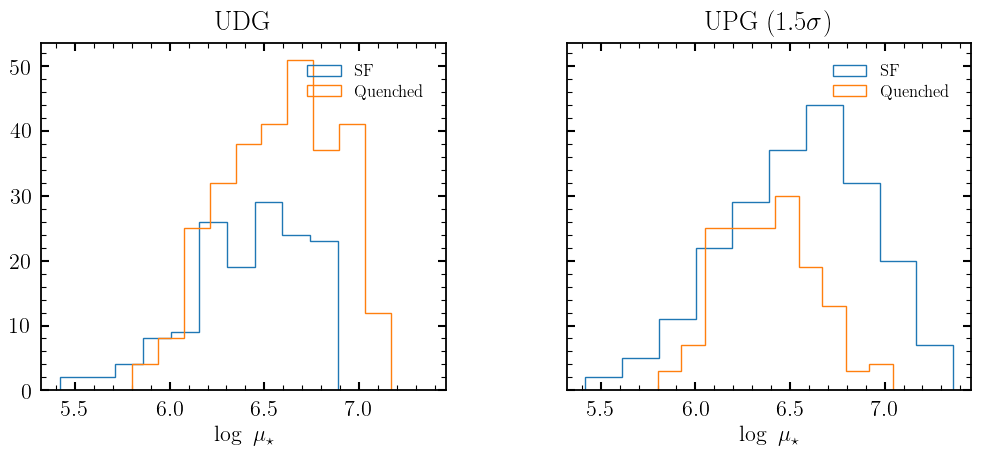

In [11]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4.6), sharey=True, sharex=True)

plt.sca(ax1)

name = 'udg'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
udg_cat.sort('g-i', reverse=True)

mu_mass = udg_cat['log_m_star'] - np.log10(np.pi * udg_cat['rhalf_phys']**2)
quenched_intercept = -0.23
V = udg_cat['mag'][:, 0] - 0.5784 * \
    (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(udg_cat['host_ang_diam_dist'].data *
                              (1 + udg_cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. 
# The original intercept is -0.23. I think 0.28 works better for our sample.
delta_MS = (udg_cat['g-i'] - (-0.067 * V_abs + quenched_intercept))

plt.hist(mu_mass[delta_MS < 0], histtype='step', label='SF')
plt.hist(mu_mass[delta_MS > 0], histtype='step', label='Quenched')

plt.xlabel(r'$\log\ \mu_\star$')
plt.title(r'UDG')
plt.legend(fontsize=12)

####################
plt.sca(ax2)

name = 'upg'
thresh = 1.5
upg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
upg_cat = upg_cat[upg_cat['completeness'] > 0.1]
upg_cat.sort('g-i', reverse=True)

mu_mass = upg_cat['log_m_star'] - np.log10(np.pi * upg_cat['rhalf_phys']**2)
quenched_intercept = -0.23
V = upg_cat['mag'][:, 0] - 0.5784 * \
    (upg_cat['mag'][:, 0] - upg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(upg_cat['host_ang_diam_dist'].data *
                              (1 + upg_cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. 
# The original intercept is -0.23. I think 0.28 works better for our sample.
delta_MS = (upg_cat['g-i'] - (-0.067 * V_abs + quenched_intercept))

plt.hist(mu_mass[delta_MS < 0], histtype='step', label='SF')
plt.hist(mu_mass[delta_MS > 0], histtype='step', label='Quenched')

plt.xlabel(r'$\log\ \mu_\star$')
plt.title(r'UPG ($1.5\sigma$)')
plt.legend(fontsize=12)


plt.subplots_adjust(wspace=0.3)

### $R_e-M_V$ plot

(-10.0, -20.0)

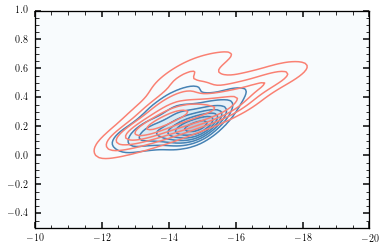

In [80]:
xmin, xmax = -10, -20
ymin, ymax = -0.5, 1

### UDG ###
name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

x = udg_cat['abs_mag'][:, 0]
y = np.log10(udg_cat['rhalf_phys'])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
cset = plt.contour(xx, yy, f, colors='steelblue')
cfset = plt.contourf(xx, yy, f, cmap='Blues', alpha=0.3)
# plt.scatter(x, y)
plt.xlim(xmin, xmax)


name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

x = udg_cat['abs_mag'][:, 0]
y = np.log10(udg_cat['rhalf_phys'])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
cset = plt.contour(xx, yy, f, colors='salmon')
# cfset = plt.contourf(xx, yy, f, cmap='Reds', alpha=0.3)
# plt.scatter(x, y)
plt.xlim(xmin, xmax)

In [4]:
from paper_figure import plot_size_distribution

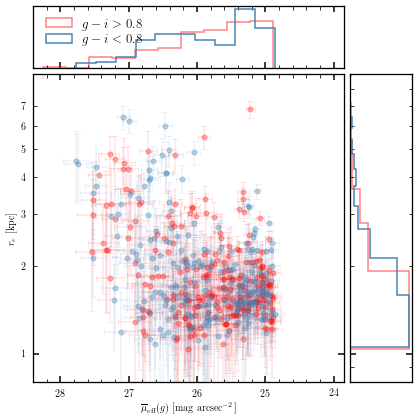

In [7]:
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]

# udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

# Distribution of the full sample after junk cuts
fig, ax = plt.subplots(figsize=(6, 6))

red = (udg_cat['g-i'].data > 0.8)

markers, caps, bars = ax.errorbar(udg_cat[red]['SB_eff_avg'][:, 0], 
            udg_cat[red]['rhalf_phys'], 
            xerr=udg_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[red]['rhalf_phys_err'],
            color='r', fmt='o', ms=5, alpha=0.3, label='$g-i > 0.8$')
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

markers, caps, bars = ax.errorbar(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_phys'], 
            xerr=udg_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[~red]['rhalf_phys_err'],
            color='steelblue', fmt='o', ms=5, alpha=0.35, label='$g-i < 0.8$')
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

ax.set_xlim(28.4, 23.85)
ax.set_ylim(0.8, 9)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm kpc]$')
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor', right=False)
ax.set_yticks([1], minor=False)
ax.set_yticklabels([1], minor=False)
ax.set_yticks([2, 3, 4, 5, 6, 7], minor=True)
ax.set_yticklabels([2, 3, 4, 5, 6, 7], minor=True)

ax_histx = ax.inset_axes((0, 1.02, 1, .2))
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=1.5,
              histtype='step', density=True, color='r', alpha=0.5, label='$g-i > 0.8$')
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=1.5,
              histtype='step', density=True, color='steelblue', label='$g-i < 0.8$')
ax_histx.set_xlim(ax.get_xlim())

ax_histy = ax.inset_axes((1.02, 0, 0.2, 1))
ax_histy.tick_params(axis="y", which='both', labelleft=False)
ax_histy.hist(udg_cat[red]['rhalf_phys'], lw=1.5,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_phys'], lw=1.5,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_yscale('log')
ax_histy.set_ylim(ax.get_ylim())

ax_histx.set_yticks([])
ax_histy.set_xticks([])
leg = ax_histx.legend(loc=(0.02, 0.26), frameon=False, fontsize=13)

### Host property
# axins = ax.inset_axes((0.5, 1-0.3, .3, .15), )
# axins.hist(udg_cat['host_z'], histtype='step', density=True, color='gray')
# axins.set_yticks([])
# axins.set_xticks([0.02, 0.04])
# axins.set_xticklabels([0.02, 0.04], fontsize=10)

plt.tight_layout()

Text(0.5, 1.1, 'UDG')

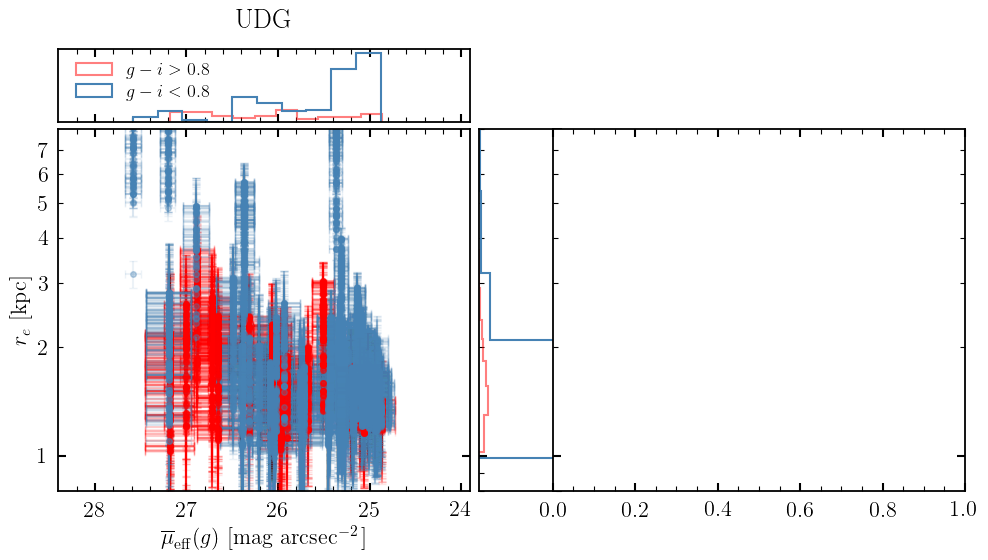

In [23]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11.7, 4.8), sharey=True)

name = 'udg'
fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220715.fits')

fig, ax1 = re_SB_distribution(fake_udg_cat, ax=ax1, xlim=(28.4, 23.9))
ax1[1].set_title("UDG", y=1.1)

---

In [11]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [12]:
from paper_figure import re_SB_distribution

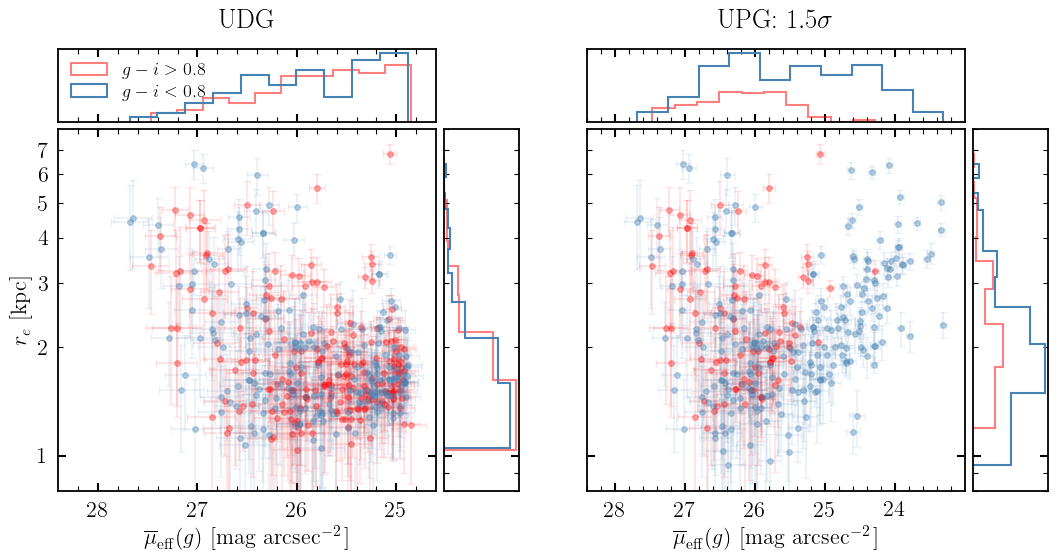

In [16]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11.7, 4.8), sharey=True)

name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fig, ax1 = re_SB_distribution(udg_cat, ax=ax1, xlim=(28.4, 24.6))
ax1[1].set_title("UDG", y=1.1)


name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fig, ax2 = re_SB_distribution(udg_cat, ax=ax2, xlim=(28.4, 23), show_legend=False)
ax2[0].set_ylabel('')
ax2[0].set_xticks([28, 27, 26, 25, 24], minor=False)
ax2[0].set_xticks(np.arange(28.4, 23, -0.2), minor=True)
ax2[1].set_xticks([28, 27, 26, 25, 24], minor=False)
ax2[1].set_xticks(np.arange(28.4, 23, -0.2), minor=True)

ax2[1].set_title("UPG: $1.5\sigma$", y=1.1)

plt.subplots_adjust(wspace=0.4)
plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/udg_upg_sample.pdf', 
            bbox_inches='tight', dpi=120)

### UDG fraction

In [79]:
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

Total angular area [deg2]: 32.70887732960614


In [80]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
from sample_cuts import post_process_cat_new_rbf
cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

In [81]:
fake_udg_cat = Table.read('./Catalog/random_field/fake_udg_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg
print(density_bkg)

1.9477083333333332


In [82]:
n_udg = (len(udg_cat) - density_bkg * total_area) / len(np.unique(cuts_cat['host_name']))
n_udg_std = np.sqrt(len(udg_cat) - density_bkg * total_area) / len(np.unique(cuts_cat['host_name']))
n_udg *= (1 / udg_cat['completeness']).mean()
n_udg_std *= (1 / udg_cat['completeness']).mean()

In [83]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('n(UDG):', n_udg, '+-', n_udg_std)
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', n_udg, '+-', n_udg_std)
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 689

LSBGs after cuts: 2510
UDGs: 412
n(UDG): 0.7633442809899098 +- 0.04090235400770302
UDG hosts: 258
UDG fraction: 0.7633442809899098 +- 0.04090235400770302

# of Candy: 340
# of Gal: 61
# of Junk: 11


In [87]:
(density_bkg) * total_area / len(udg_cat)

0.15462949744866897

In [73]:
## assumeeach MW has 5 satellites. Then the fraction of UDG out of all MW satellites:
n_udg / 5

0.15266885619798196

In NGVS, they have 15 UDGs out of 404 satellites.

In [22]:
15 / 404

0.03712871287128713

In [88]:
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

Total angular area [deg2]: 32.36912377009267


In [89]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
from sample_cuts import post_process_cat_new_rbf
cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

In [90]:
fake_udg_cat = Table.read(f'./Catalog/random_field/fake_upg_cat_{thresh}sigma_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg
print(density_bkg)

2.1152083333333334


In [91]:
n_udg = (len(udg_cat) - density_bkg * total_area) / len(np.unique(cuts_cat['host_name']))
n_udg_std = np.sqrt(len(udg_cat) - density_bkg * total_area) / len(np.unique(cuts_cat['host_name']))
n_udg *= (1 / udg_cat['completeness']).mean()
n_udg_std *= (1 / udg_cat['completeness']).mean()

In [92]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UPGs:', len(udg_cat))
print('UPG hosts:', len(np.unique(udg_cat['host_name'])))

print('UPG fraction:', n_udg, '+-', n_udg_std)

print('UPG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 689

LSBGs after cuts: 2510
UPGs: 337
UPG hosts: 239
UPG fraction: 0.6077342961629361 +- 0.03708645051763874
UPG fraction: 0.48911465892597966

# of Candy: 288
# of Gal: 41
# of Junk: 8


In [93]:
(density_bkg) * total_area / len(udg_cat)

0.20316747875726437

In [327]:
(1 - 0.11) * 371 / (689 * 5) # UPG fraction of my sample

0.09584615384615384

In [328]:
24 / 404, np.sqrt(24) / 404

(0.0594059405940594, 0.012126186845461276)